## Simple RNN
https://medium.com/@thisislong/building-a-recurrent-neural-network-from-scratch-ba9b27a42856
<br>https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/
<br>input data : 조업편차분석
<br>input data size : (53, 7596)
<br>output data feature : 'A10' column

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt # only for graph visualization only

In [2]:
# file upload and parsing
# separating input and output data
file_dir = '../00_cnn/조업편차분석.txt'

with open(file_dir, 'r') as f:
    input_data = [x.strip().split(' ')[1:] for x in f.readlines()]
    f.close()

input_data = np.array(input_data[1:])
y = input_data[:, 9].astype('float')
x = np.delete(input_data, np.s_[9:10], axis = 1).astype('float')

np.shape(x), np.shape(y)

((7596, 53), (7596,))

### Define necessary functions
- train-test split
- normalization
- activation functions (derivatives)
- loss functions
- initialize parameters
- forward pass
- BPTT (backpropagation through time)
- weight update

In [3]:
# train-test split
def train_test_split(x, y, ratio=0.7):
    split_idx = int(len(x)*ratio)
    trainX = x[:split_idx]
    trainy = y[:split_idx]

    testX = x[split_idx:]
    testy = y[split_idx:]

    return trainX, testX, trainy, testy

In [4]:
#normalization
def Standard(X):
    X_scaled = ( X - X.mean(axis=0) ) / X.std(axis=0)
    return X_scaled, X.mean(axis=0), X.std(axis=0)

def inverse_Standard(X_scaled, mean, std):
    X = ( X_scaled * std ) + mean
    return X

In [5]:
#activation functions + derivatives
def sigmoid(x, derivative=False):
    if derivative == True:
        return x*(1-x)
    else:
        return 1 / (1 + np.exp(-x))
    
def tanh(x, derivative=False):
    if derivative:
        return 1-x**2 #np.tanh(x)**2
    else:
        return np.tanh(x)


In [6]:
#loss functions
# MSE loss function
def MSE(y_pred, y_true):
    total_error = np.sum((y_pred - y_true)**2)
    return total_error / len(y_true)

# MAE loss function
def MAE(y_pred, y_true):
    total_error = np.sum(np.abs(y_pred - y_true))
    return total_error / len(y_true)

#accuracy calculation
def r_squared(y_pred, y_true):
    ssr = np.sum((y_pred-y_true)**2)
    sst = np.sum((y_true.mean()-y_true)**2)
    return 1- (ssr/sst)

In [16]:
#initialize parameters
def initialize_parameters(input_size, hidden_size, output_size): 
    #model_structure_layout eg) [input_size, (hidden_size), output_size] -> [53, 10, 10, 1]
    np.random.seed(0)
    # U = np.random.uniform(-1, 1, (hidden_size, input_size)) # (hidden_size, input_size)
    # W = np.random.uniform(-1, 1, (hidden_size, hidden_size))# (hidden_size, hidden_size)
    # V = np.random.uniform(-1, 1, (output_size, hidden_size))# (output_size, hidden_size)
    U = np.random.randn(hidden_size, input_size) * 0.01  # (hidden_size, input_size)
    W = np.random.randn(hidden_size, hidden_size) * 0.01 # (hidden_size, hidden_size)
    V = np.random.randn(output_size, hidden_size) * 0.01 # (output_size, hidden_size)
    bh = np.zeros((hidden_size, 1))  # (hidden_size, 1)
    by = np.zeros((output_size, 1))  # (output_size, 1)
        
    parameters = [U, W, V, bh, by]

    return parameters

In [17]:
#forward pass
def forward_pass(X, parameters):
    U, W, V, bh, by = parameters #retrieve the weights
    #U = (64, 53)
    #W = (64, 64)
    #V = (1, 64)

    #saving all the hidden state values
    hs = {}
    ys = {}
    #preallocating previous hidden state value
    h_prev = np.zeros((W.shape[0], 1))
    for t, x in enumerate(X): #for each data set of 53 features
        x = x.reshape(-1,1)
        mulU = np.dot(U, x) #(64, 53) dot (53, 1)
        mulW = np.dot(W, h_prev) #(64, 64) for (64, 1)
        h_prev  = tanh(mulU + mulW + bh) # (64, 1)
        y = np.dot(V, h_prev) + by # (1, 64) dot (64, 1)
        hs[t] = h_prev
        ys[t] = y


    return ys, hs

In [18]:
#BPTT
def BPTT(parameters, ys, hs, X, y): #hs (64,64)
    
    U, W, V, bh, by = parameters #retrieve the weights
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
    dbh = np.zeros(bh.shape)
    dby = np.zeros(by.shape)
    dh_next = np.zeros_like(hs[0])
    #derivative of the last y output 
    # #cache= (5818, 64)
    #cache[t] = (64,)
    y_pred = np.squeeze(list(ys.values()))
    dy = y_pred - y # (5###, )

    for t in reversed(range(len(X))):
        x = X[t].reshape(-1,1)

        dV += np.dot(dy[t], hs[t].T)
        dby += dy[t]

        dh = np.dot(V.T, dy[t]) + dh_next
        dhraw = tanh(hs[t], derivative=True) * dh
        dbh += dhraw

        dU += np.dot(dhraw, x.T)
        if t>0:
            dW += np.dot(dhraw, hs[t-1].T)
        else:
            dW += np.dot(dhraw, np.zeros_like(hs[0]).T)

        dh_next = np.dot(W.T, dhraw)

    for dparam in [dU, dW, dV, dbh, dby]:
        np.clip(dparam, -1, 1, out=dparam)

    gradients = [dU, dW, dV, dbh, dby]

    return gradients

In [19]:
#weight update
def update_parameters(parameters, gradients, learning_rate):
    dU, dW, dV, dbh, dby = gradients
    U, W, V, bh, by = parameters

    U -= learning_rate*dU
    W -= learning_rate*dW 
    V -= learning_rate*dV 
    bh -= learning_rate*dbh 
    by -= learning_rate*dby 

    parameters = [U, W, V, bh, by]

    return parameters 

### Running the SimpleRNN model

In [20]:
# data preprocessing
x_scaled, X_mean, X_std = Standard(x)
y_scaled, y_mean, y_std = Standard(y)
trainX, testX, trainy, testy = train_test_split(x_scaled, y_scaled)
print(f'train set of input data:\t{trainX.shape}\ntest set of input data:\t\t{testX.shape}')
trainy.shape, testy.shape

train set of input data:	(5317, 53)
test set of input data:		(2279, 53)


((5317,), (2279,))

In [21]:
# hyperparameter settings
learning_rate = 0.01    
epochs = 500
hidden_size = 64         
output_size = 1
input_size = trainX.shape[1]
input_size

53

In [22]:
# training
mse = []
rs = []
mae = []

parameters = initialize_parameters(input_size, hidden_size, output_size)

for epoch in range(epochs):

    ys, hs = forward_pass(trainX, parameters)
    # print(f'P : {parameters[0][0][0]}, ys : {ys[50]}, hs : {hs[0][0][0]}')

    # calculate loss
    y_pred = np.squeeze(list(ys.values()))
    loss = MSE(y_pred, trainy)
    loss_2 = MAE(y_pred, trainy)
    acc = r_squared(y_pred, trainy)
    mse.append(loss)
    mae.append(loss_2)
    rs.append(acc)

    gradients = BPTT(parameters, ys, hs, trainX, trainy)
    parameters = update_parameters(parameters, gradients, learning_rate, trainy)
    # print('G :  ', gradients[0][0][0])l

    if epoch == 1 or epoch % 100 == 9:
        print(f'MSE for epoch # {epoch+1} : {loss}')

MSE for epoch # 2 : 0.7019747266799181
MSE for epoch # 10 : 1.1003532273706107
MSE for epoch # 110 : 0.10275368109126663
MSE for epoch # 210 : 0.06251056874069326
MSE for epoch # 310 : 0.047636517045215085
MSE for epoch # 410 : 0.027664055522425908


R-square	:	0.969234580818548      
RMAE		:	0.34148598066613234      
MAE		:	0.1166126749915101      
MSE		:	0.021761367976899357


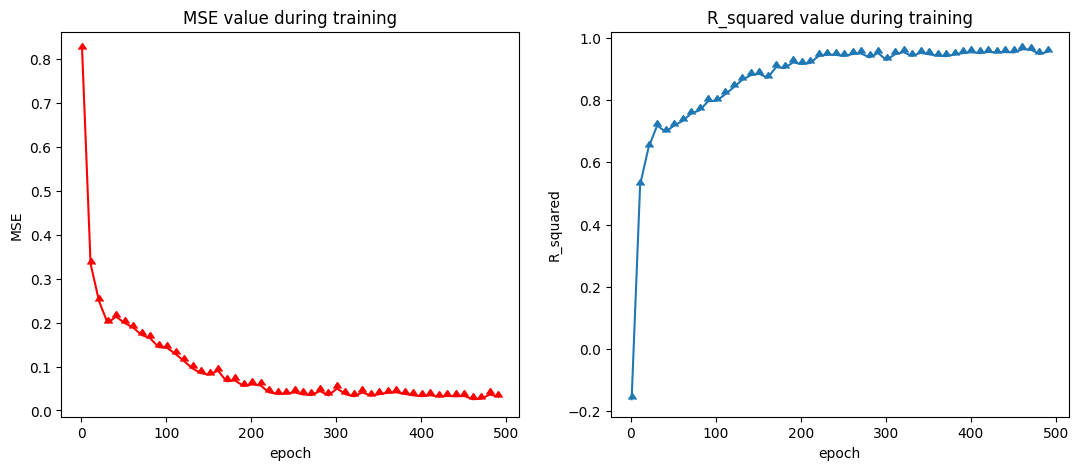

In [23]:
print(f'R-square\t:\t{rs[np.argmax(rs)]}\
      \nRMAE\t\t:\t{np.sqrt(mae[np.argmin(mse)])}\
      \nMAE\t\t:\t{np.min(mae)}\
      \nMSE\t\t:\t{np.min(mse)}')

# visualize loss graph
visual_pts = 10

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot(np.arange(1,len(mse)+1, visual_pts), mse[::visual_pts], marker=10, color = 'r')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('MSE value during training')

plt.subplot(1,2,2)
plt.plot(np.arange(1,len(rs)+1, visual_pts), rs[::visual_pts], marker=10)
plt.xlabel('epoch')
plt.ylabel('R_squared')
plt.title('R_squared value during training')
plt.show()



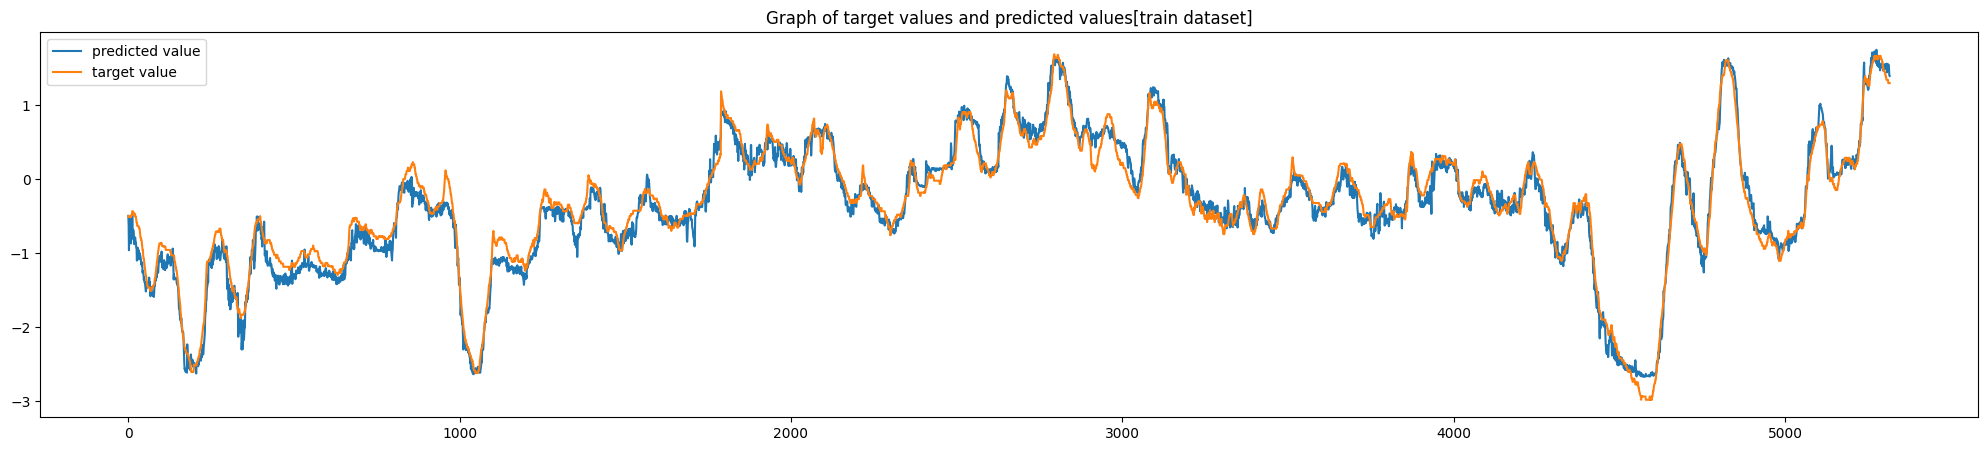

In [ ]:
# visualization of model output values
plt.figure(figsize=(25,5))
# plt.xlabel('Data index number')
# plt.ylabel('Feature [A10] value')

# plt.subplot(1,2,1)
plt.plot(y_pred, label = 'predicted value')
plt.plot(trainy, label = 'target value')
plt.title('Graph of target values and predicted values[train dataset]')
plt.legend()

# plt.subplot(1,2,2)
# plt.plot(A2[0])
# plt.title('Graph of predicted values[train dataset]')
plt.show()

In [ ]:
# testing
# retrieve the  parameters
tU, tW, tV, tbh, tby = parameters

ty_pred = []
#preallocating previous hidden state value
h_prev = np.zeros((tW.shape[0], 1))
for t, x in enumerate(x_scaled): #for each data set of 53 features
    x = x.reshape(-1,1)
    mulU = np.dot(tU, x) #(64, 53) dot (53, 1)
    mulW = np.dot(tW, h_prev) #(64, 64) for (64, 1)
    h_prev  = tanh(mulU + mulW + tbh) # (64, 1)
    y = np.dot(tV, h_prev) + tby # (1, 64) dot (64, 1)
    ty_pred.append(y)

y_pred = np.squeeze(ty_pred)

tloss = MSE(y_pred, y_scaled)
tloss_2 = MAE(y_pred, y_scaled)
tacc = r_squared(y_pred, y_scaled)

unscaled_y_true = inverse_Standard(y_scaled, y_mean, y_std)
unscaled_y_pred = inverse_Standard(y_pred, y_mean, y_std)
# r_squared(unscaled_y_pred[0][:4000], unscaled_y_true[:4000])

print(f'Model results for test dataset: \
      \nR-square\t:\t{tacc}\
      \nRMAE\t\t:\t{np.sqrt(tloss_2)}\
      \nMAE\t\t:\t{tloss_2}\
      \nMSE\t\t:\t{tloss}')

Model results for test dataset:       
R-square	:	0.7578685124423021      
RMAE		:	0.5528620347007572      
MAE		:	0.3056564294134613      
MSE		:	0.24213148755769787


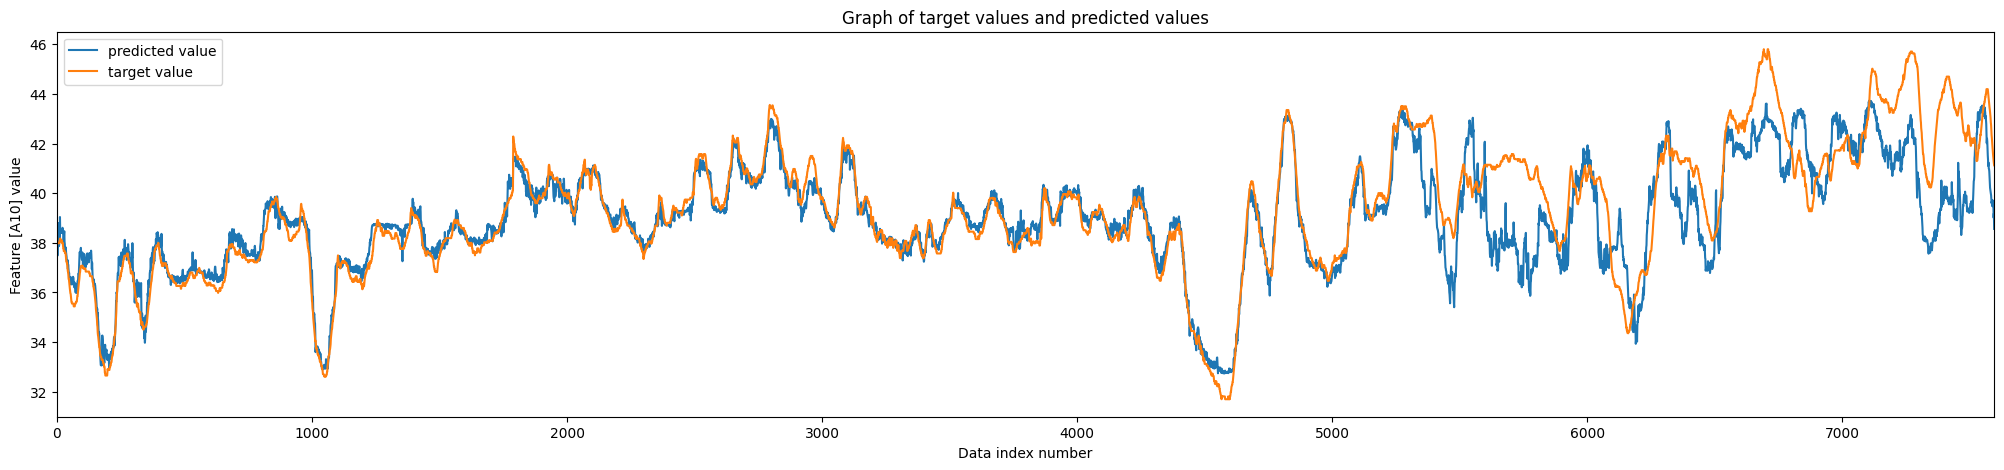

In [ ]:
# visualization of model output values and the target values
plt.figure(figsize=(25,5))
plt.xlabel('Data index number')
plt.ylabel('Feature [A10] value')
plt.title('Graph of target values and predicted values')
plt.plot(unscaled_y_pred, label = 'predicted value')
plt.plot(unscaled_y_true, label = 'target value')
plt.xlim([0, len(unscaled_y_true)])
plt.legend()
plt.show()